In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

### Image Generation from Audio

In [2]:
from pathlib import Path
from IPython.display import Audio
import librosa
import librosa.display
import matplotlib.pyplot as plt
from utils import read_file, transform_path

In [3]:
DATA = Path('data')

# these folders must be in place
NSYNTH_AUDIO = DATA/'nsynth_audio'
TRAIN_AUDIO_PATH = NSYNTH_AUDIO/'train'
VALID_AUDIO_PATH = NSYNTH_AUDIO/'valid'

# these folders will be created
NSYNTH_IMAGES = DATA/'nsynth_images'
TRAIN_IMAGE_PATH = NSYNTH_IMAGES/'train'
VALID_IMAGE_PATH = NSYNTH_IMAGES/'valid'

In [4]:
train_acoustic_fnames = [f.name for f in TRAIN_AUDIO_PATH.iterdir()
                         if 'acoustic' in f.name]
valid_acoustic_fnames = [f.name for f in VALID_AUDIO_PATH.iterdir()
                         if 'acoustic' in f.name]
len(train_acoustic_fnames), len(valid_acoustic_fnames)

(102165, 5124)

In [5]:
fn = train_acoustic_fnames[5]; fn

'flute_acoustic_022-077-050.wav'

In [6]:
Audio(str(TRAIN_AUDIO_PATH/fn))

In [7]:
x, sr = read_file(fn, TRAIN_AUDIO_PATH)
x.shape, sr, x.dtype

((64000,), 16000, dtype('float32'))

In [8]:
def log_mel_spec_tfm(fname, src_path, dst_path):
    x, sample_rate = read_file(fname, src_path)
    
    n_fft = 1024
    hop_length = 512
    n_mels = 64
    fmin = 20
    fmax = sample_rate / 2 
    
    mel_spec_power = librosa.feature.melspectrogram(x, sr=sample_rate, n_fft=n_fft, 
                                                    hop_length=hop_length, 
                                                    n_mels=n_mels, power=2.0, 
                                                    fmin=fmin, fmax=fmax)
    mel_spec_db = librosa.power_to_db(mel_spec_power, ref=np.max)
    dst_fname = dst_path / (fname[:-4] + '.png')
    plt.imsave(dst_fname, mel_spec_db)

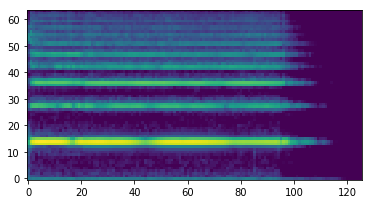

In [12]:
log_mel_spec_tfm(fn, TRAIN_AUDIO_PATH, Path('.'))
img = plt.imread('./flute_acoustic_022-077-050.png')
plt.imshow(img, origin='lower');

In [ ]:
transform_path(TRAIN_AUDIO_PATH, TRAIN_IMAGE_PATH, log_mel_spec_tfm, 
               fnames=train_acoustic_fnames, delete=True)

In [ ]:
transform_path(VALID_AUDIO_PATH, VALID_IMAGE_PATH, log_mel_spec_tfm, 
               fnames=valid_acoustic_fnames, delete=True)

### Run Image Classifier

In [19]:
from fastai import *
from fastai.vision import *

In [29]:
instrument_family_pattern = r'(\w+)_\w+_\d+-\d+-\d+.png$'

data = (ImageItemList.from_folder(NSYNTH_IMAGES)
            .split_by_folder()
            .label_from_re(instrument_family_pattern)
            .databunch())
data.c, data.classes

(10,
 ['mallet',
  'string',
  'guitar',
  'brass',
  'keyboard',
  'reed',
  'vocal',
  'flute',
  'bass',
  'organ'])

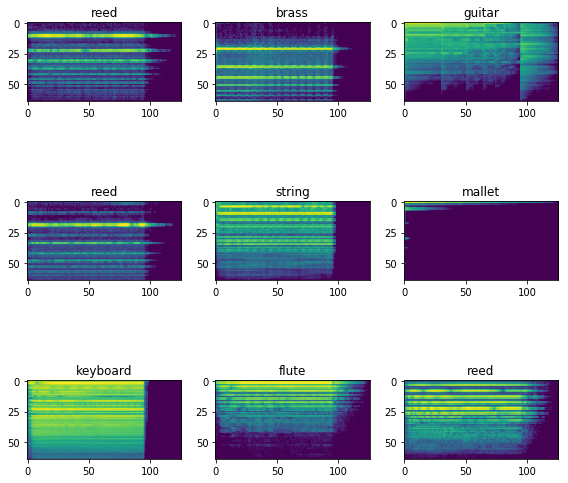

In [41]:
data.show_batch(3, figsize=(8,8), hide_axis=False)

In [37]:
learn = create_cnn(data, models.resnet18, metrics=accuracy)
learn.fit(1)

Total time: 01:13
epoch  train_loss  valid_loss  accuracy
1      1.687583    1.735304    0.423792  (01:13)



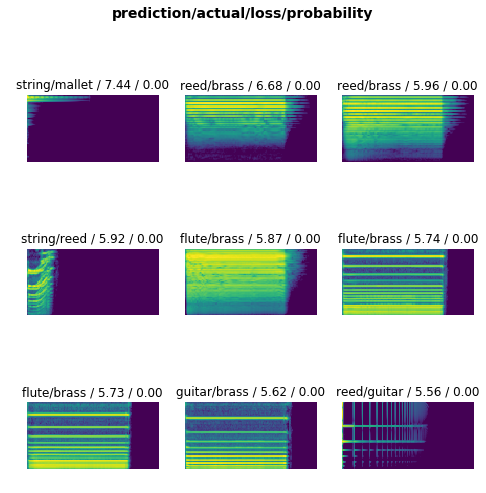

In [40]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(8, 8))

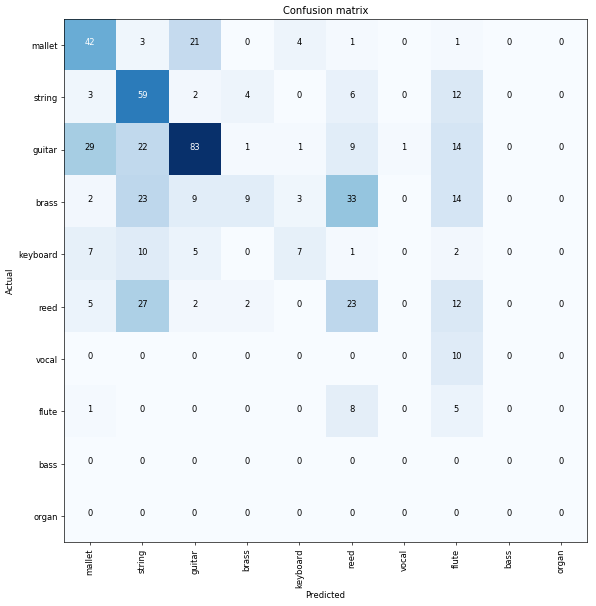

In [42]:
interp.plot_confusion_matrix(figsize=(10, 10), dpi=60)

In [43]:
interp.most_confused(min_val=2)

[('brass', 'reed', 33),
 ('guitar', 'mallet', 29),
 ('reed', 'string', 27),
 ('brass', 'string', 23),
 ('guitar', 'string', 22),
 ('mallet', 'guitar', 21),
 ('guitar', 'flute', 14),
 ('brass', 'flute', 14),
 ('string', 'flute', 12),
 ('reed', 'flute', 12),
 ('keyboard', 'string', 10),
 ('vocal', 'flute', 10),
 ('guitar', 'reed', 9),
 ('brass', 'guitar', 9),
 ('flute', 'reed', 8),
 ('keyboard', 'mallet', 7),
 ('string', 'reed', 6),
 ('keyboard', 'guitar', 5),
 ('reed', 'mallet', 5),
 ('mallet', 'keyboard', 4),
 ('string', 'brass', 4),
 ('mallet', 'string', 3),
 ('string', 'mallet', 3),
 ('brass', 'keyboard', 3)]